# symmetric_quantile-normalized_score

## Import necessary packages

In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

## Initialize the ballot set dataframe
This can also be loaded in from a .csv file.

Each row is a voter, each column is a candidate.

In [284]:
score_ballot_dictionary = {
    'EVELYN': [33, 13, 71, 32, 25, 27, 27, 32, 56, 77, 44, 20],
    'FRANK': [42, 84, 50, 81, 43, 28, 97, 59, 2, 59, 99, 85],
    'GEORGIA': [13, 94, 2, 87, 94, 96, 27, 19, 23, 66, 50, 21],
    'HAROLD': [0, 104, 2, 2, 0, 3, 8, 7, 100, 5, 8, 9]
}

""" # In this example, the first column represents a Condorcet winner, but they will lose to the second column candidate under standard score voting.
score_ballot_dictionary = {
    'EVELYN':   [1, 0,  0, 10],
    'FRANK':    [1, 10, 0,  0],
    'GEORGIA':  [10, 9, 0,  0]
}
# symmetric quantile-normalization, in contrast, will naturally select the Condorcet winner.
 """
""" # In this example, there is no Condorcet winner.
score_ballot_dictionary = {
    'EVELYN':  [10,  3,  0, 0],
    'FRANK':   [ 0, 10,  9, 1],
    'GEORGIA': [ 2,  0, 10, 1]
}
# symmetric quantile-normalization is indeterminate... """

score_ballot_df = pd.DataFrame(score_ballot_dictionary).T
#score_ballot_df = score_ballot_df.drop([10,9,6,1,3,8,11,7,2,5], axis=1)
score_ballot_df.columns = range(len(score_ballot_df.columns))
score_ballot_df

,0,1,2,3,4,5,6,7,8,9,10,11
EVELYN,33,13,71,32,25,27,27,32,56,77,44,20
FRANK,42,84,50,81,43,28,97,59,2,59,99,85
GEORGIA,13,94,2,87,94,96,27,19,23,66,50,21
HAROLD,0,104,2,2,0,3,8,7,100,5,8,9


## Define auxiliary functions to linearly scale score ballots to span a pre-defined range.

Include a default case when a ballot has no variation.

In [285]:
def get_scaled_score_ballot(score_ballot, min=0, max=1):
    max_score = np.max(score_ballot)
    min_score = np.min(score_ballot)

    score_range = max_score - min_score
    mid_score = (min+max)/2
    #print("score range: ", score_range)

    if score_range == 0:
        scaled_score_ballot = np.full_like(score_ballot, mid_score)
    else:
        scaled_score_ballot = min + ((score_ballot - min_score) / score_range) * (max - min)
    return scaled_score_ballot

def get_scaled_score_ballot_df(score_ballot_df, min=0, max=1):
    # Use apply to vectorize operation across rows
    scaled_score_ballot_df = score_ballot_df.apply(get_scaled_score_ballot, args=(min, max), axis=1)
    return scaled_score_ballot_df

scaled_score_ballot_df = get_scaled_score_ballot_df(score_ballot_df)
scaled_score_ballot_df

,0,1,2,3,4,5,6,7,8,9,10,11
EVELYN,0.312500,0.000000,0.906250,0.296875,0.187500,0.218750,0.218750,0.296875,0.671875,1.000000,0.484375,0.109375
FRANK,0.412371,0.845361,0.494845,0.814433,0.422680,0.268041,0.979381,0.587629,0.000000,0.587629,1.000000,0.855670
GEORGIA,0.117021,0.978723,0.000000,0.904255,0.978723,1.000000,0.265957,0.180851,0.223404,0.680851,0.510638,0.202128
HAROLD,0.000000,1.000000,0.019231,0.019231,0.000000,0.028846,0.076923,0.067308,0.961538,0.048077,0.076923,0.086538


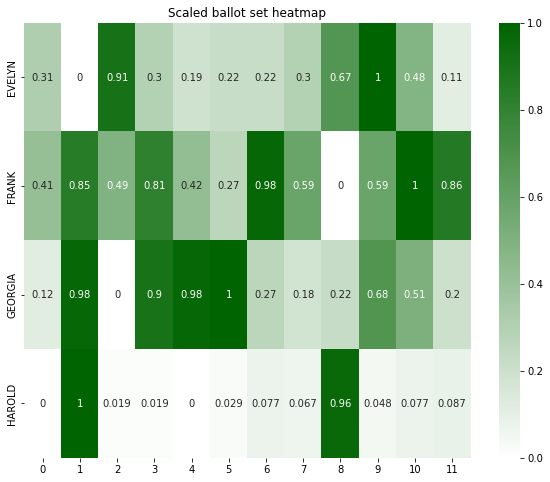

In [286]:
# Create a custom colormap
# This example uses blue, but you can change 'blue' to any color of your choice.
single_color_cmap = LinearSegmentedColormap.from_list('custom_blue', ['white', 'darkgreen'])

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(scaled_score_ballot_df, cmap=single_color_cmap, annot=True)
plt.title('Scaled ballot set heatmap')
plt.show()

In [287]:
sorted_scaled_score_matrix = np.sort(scaled_score_ballot_df, axis=1)
single_color_cmap = LinearSegmentedColormap.from_list('custom_blue', ['white', 'darkgreen'])

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_scaled_score_matrix, cmap=single_color_cmap, annot=True)
plt.title('Sorted ballot scores heatmap')
plt.show()

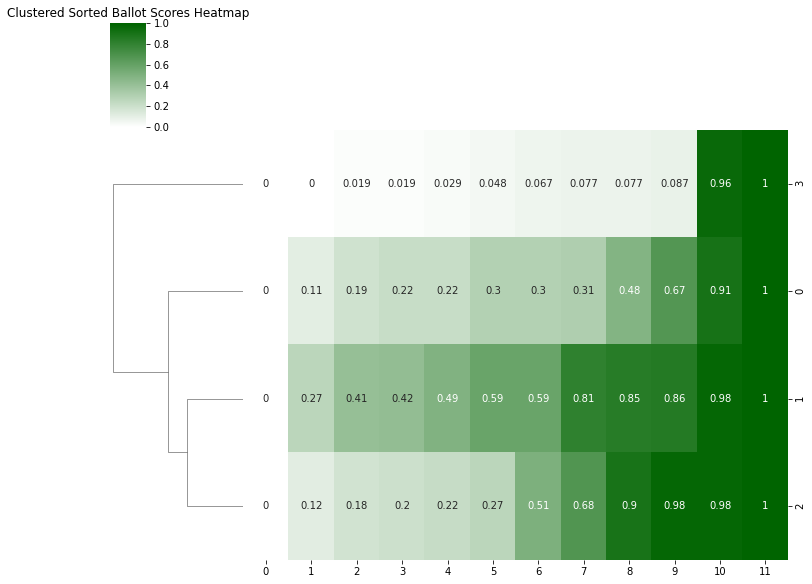

In [ ]:
# Assuming `sorted_scaled_score_matrix` is your sorted and scaled score matrix as a NumPy array
# and `single_color_cmap` is your colormap

# Define your custom color map
single_color_cmap = LinearSegmentedColormap.from_list('custom_blue', ['white', 'darkgreen'])

# Perform hierarchical clustering and create the clustered heatmap
sns.clustermap(sorted_scaled_score_matrix, cmap=single_color_cmap, figsize=(10, 8), annot=True, col_cluster=False)

plt.title('Clustered Sorted Ballot Scores Heatmap')
plt.show()

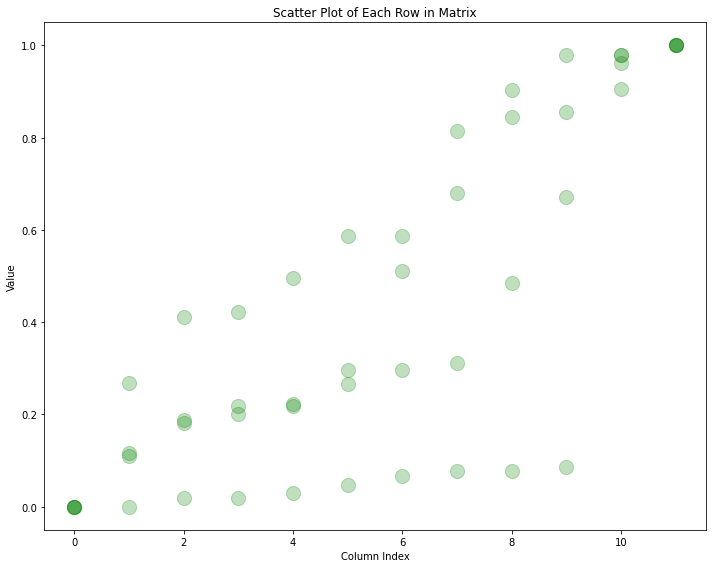

In [ ]:
# Generate a scatter plot
n_rows, n_cols = sorted_scaled_score_matrix.shape
plt.figure(figsize=(10, 8))

for i in range(n_rows):
    # Create x values based on the index of columns
    x_values = np.arange(n_cols)
    # Extract y values directly from the matrix
    y_values = sorted_scaled_score_matrix[i, :]

    # Plot each row's points with jitter on the scatter plot
    plt.scatter(x_values, y_values, alpha=0.25, c='green', s=200)

plt.title('Scatter Plot of Each Row in Matrix')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

## Define a function to compute the asymmetric quantile normalized score values.

In [ ]:
def get_quantile_normalized_values(score_ballot_df):
    # Sort the values in each column
    score_ballot_df = score_ballot_df.T
    sorted_df = np.sort(score_ballot_df, axis=0)
    
    # Calculate the mean of each row across the sorted columns
    mean_values = np.mean(sorted_df, axis=1)
    
    # Rank the values in the original dataframe
    ranks = score_ballot_df.stack().groupby(score_ballot_df.rank(method='min').stack().astype(int)).mean()
    
    # Replace ranks with mean values
    #normalized_df = score_ballot_df.rank(method='min').stack().astype(int).map(ranks).unstack()
    #print(list(mean_values))
    return list(mean_values)

get_quantile_normalized_values(scaled_score_ballot_df)


[0.0,
 0.12360937842728668,
 0.19998824177029376,
 0.21569721029409286,
 0.24146144249751125,
 0.2996345589662038,
 0.36561246403985354,
 0.4711767826108964,
 0.5777285552035704,
 0.6482017422216411,
 0.9564733272731875,
 1.0]

## Simply combine the linear scaling to compute asymmetric quantile normalized values over scaled ballots.

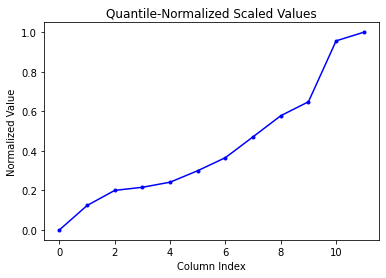

[0.         0.12360938 0.19998824 0.21569721 0.24146144 0.29963456
 0.36561246 0.47117678 0.57772856 0.64820174 0.95647333 1.        ]


In [ ]:

def get_quantile_normalized_scaled_values(score_ballot_df, min=0, max=1):
    scaled_score_ballot_df = get_scaled_score_ballot_df(score_ballot_df, min, max)
    return np.array(get_quantile_normalized_values(scaled_score_ballot_df))

quantile_normalized_scaled_values=get_quantile_normalized_scaled_values(score_ballot_df)
plt.plot(quantile_normalized_scaled_values, marker='.', c='blue')
plt.title('Quantile-Normalized Scaled Values')
plt.xlabel('Column Index')
plt.ylabel('Normalized Value')
plt.show()
print(quantile_normalized_scaled_values)

## Define a simple function to transform the asymmetric quantile normalized values into a symmetric version that preserves cancellation properties.

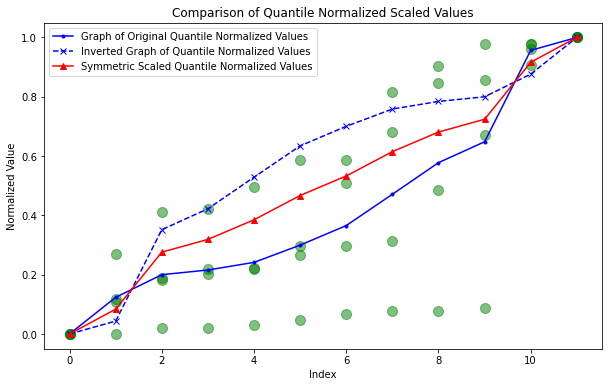

In [ ]:
def symmetric_bimonotone_function(a,b, mode = 'mean'):
    if mode == 'mean':
        return (a+b)/2

def get_symmetric_quantile_normalized_scaled_values(score_ballot_df, mode='mean'):
    scaled_quantile_normalized_values = get_quantile_normalized_scaled_values(score_ballot_df, 0, 1)

    num_values = len(scaled_quantile_normalized_values)

    # Vectorized computation
    symmetric_scaled_quantile_normalized_values = symmetric_bimonotone_function(scaled_quantile_normalized_values, (1 - scaled_quantile_normalized_values[::-1]), mode)

    return symmetric_scaled_quantile_normalized_values

symmetric_scaled_quantile_normalized_values=get_symmetric_quantile_normalized_scaled_values(score_ballot_df)
plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary

# Original quantile normalized scaled values
plt.plot(quantile_normalized_scaled_values, label='Graph of Original Quantile Normalized Values', color='blue', marker='.', linestyle='-')

# Inverted and shifted values for comparison
plt.plot(1 + np.sort(-quantile_normalized_scaled_values), label='Inverted Graph of Quantile Normalized Values', color='blue', marker='x', linestyle='--')

# Symmetric scaled quantile normalized values
plt.plot(symmetric_scaled_quantile_normalized_values, label='Symmetric Scaled Quantile Normalized Values', color='red', marker='^', linestyle='-')

plt.title('Comparison of Quantile Normalized Scaled Values')  # Add a plot title
plt.xlabel('Index')  # X-axis label
plt.ylabel('Normalized Value')  # Y-axis label
plt.legend()  # Show legend to identify lines
for i in range(n_rows):
    # Create x values based on the index of columns
    x_values = np.arange(n_cols)
    # Extract y values directly from the matrix
    y_values = sorted_scaled_score_matrix[i, :]

    # Plot each row's points with jitter on the scatter plot
    plt.scatter(x_values, y_values, alpha=0.50, c='green', s=100)
plt.show()

## Modify ordinary quantile normalization by replacing asymmetric quantile values with their symmetrical adjusted values.

Adjustments are also made to account for repeated values. When values are tied in rank, they are assigned the mean of the values corresponding to the ranks they would normally represent if they were different. This still preserves symmetry and hence the desired cancellation properties.

In [ ]:
def get_symmetric_quantile_normalized_scaled_score_ballot_df(score_ballot_df):
    #print(score_ballot_df)
    # Rank the values in each column
    symmetric_quantile_normalized_scaled_score_values = get_symmetric_quantile_normalized_scaled_values(score_ballot_df)
    #print((symmetric_quantile_normalized_scaled_score_values))
    #print('\n')
    #print("\nOriginal score ballots:\n", score_ballot_df)

    score_rankings_df = score_ballot_df.rank(axis=1, method='first').astype(int) -1
    #print("\nScore ranking ballots:\n ", score_rankings_df)
    #print('\n')
    #print(score_ballot_df)

    as_if_unique_normalized_df = score_rankings_df.applymap(lambda x: symmetric_quantile_normalized_scaled_score_values[x])
    #print("\nNormalized as if scores are unique:\n ", as_if_unique_normalized_df)

    corrected_df = as_if_unique_normalized_df.copy()

    # March 17, 2024: Should paralellize over rows.
    # Need score_ballot_df_row, and as_if_unique_normalized_df, as well as perhaps corrected_df which is a copy of it.
    # Actually, I think I just need the original score_ballot_df_row, and the corresponding row in as_if_unique_normalized_df.
    num_cols = len(score_rankings_df.columns)
    # March 17, 2024: It should be possible to "pre-flag" each row as having repeats during the previous processes.
    for index, row in score_ballot_df.iterrows():
        # Get the scores and their corresponding ranks from the original dataframe
        scores_with_ranks = row.rank(method='min').astype(int) -1
        #print("scores with ranks: ", scores_with_ranks.values)
        unique_scores = row.unique()
        # Skip over rows that don't have repeated scores, since those have already been processed.
        if len(unique_scores) < num_cols:
            for score in unique_scores:
                # Find the ranks (indices) associated with this score
                ranks_for_score = scores_with_ranks[row == score].values
                # Calculate the average of the symmetric scaled values for these ranks
                avg_value = as_if_unique_normalized_df.loc[index, ranks_for_score].mean()
                # Assign this average back to the corresponding locations in the corrected dataframe
                corrected_df.loc[index, ranks_for_score] = avg_value
    return corrected_df



symmetric_scaled_quantile_normalized_score_ballot_df=get_symmetric_quantile_normalized_scaled_score_ballot_df(score_ballot_df)
print("Symmetric quantile-normalized score ballot set: \n")
symmetric_scaled_quantile_normalized_score_ballot_df
#print(score_ballot_df)

Symmetric quantile-normalized score ballot set: 



,0,1,2,3,4,5,6,7,8,9,10,11
EVELYN,0.614858,0.000000,0.916432,0.467011,0.275893,0.318984,0.385142,0.532989,0.724107,1.000000,0.681016,0.083568
FRANK,0.275893,0.681016,0.385142,0.614858,0.318984,0.083568,0.916432,0.467011,0.000000,0.532989,1.000000,0.724107
GEORGIA,0.083568,0.724107,0.000000,0.681016,0.916432,1.000000,0.467011,0.275893,0.385142,0.614858,0.532989,0.318984
HAROLD,0.000000,1.000000,0.275893,0.318984,0.083568,0.385142,0.614858,0.532989,0.916432,0.467011,0.681016,0.724107


## Work in progress: improve parallelization of normalization process.

In [ ]:
from concurrent.futures import ProcessPoolExecutor

def process_matched_rows(args):
    score_row, as_if_unique_row = args
    # Get the scores and their corresponding ranks from the original dataframe
    scores_with_ranks = score_row.rank(method='min').astype(int) -1
    #print("scores with ranks: ", scores_with_ranks.values)
    unique_scores = score_row.unique()
    if len(unique_scores) < len(as_if_unique_row):
        corrected_row = as_if_unique_row 
        for score in unique_scores:
            # Find the ranks (indices) associated with this score
            ranks_for_score = scores_with_ranks[score_row == score].values
            # Calculate the average of the symmetric scaled values for these ranks
            avg_value = as_if_unique_row[ranks_for_score].mean()
            # Assign this average back to the corresponding locations in the corrected dataframe
            corrected_row[ranks_for_score] = avg_value
    return corrected_row

""" def par_get_symmetric_quantile_normalized_scaled_score_ballot_df(score_ballot_df, min=0, max=1):
    #print(score_ballot_df)
    # Rank the values in each column
    symmetric_quantile_normalized_scaled_score_values = get_symmetric_quantile_normalized_scaled_values(score_ballot_df, min, max)
    #print((symmetric_quantile_normalized_scaled_score_values))
    #print('\n')
    #print("\nOriginal score ballots:\n", score_ballot_df)

    score_rankings_df = score_ballot_df.rank(axis=1, method='first').astype(int) -1
    #print("\nScore ranking ballots:\n ", score_rankings_df)
    #print('\n')
    #print(score_ballot_df)

    as_if_unique_normalized_df = score_rankings_df.applymap(lambda x: symmetric_quantile_normalized_scaled_score_values[x])
    #print("\nNormalized as if scores are unique:\n ", as_if_unique_normalized_df)

    corrected_df = as_if_unique_normalized_df.copy()

    # March 17, 2024: Should paralellize over rows.
    # Need score_ballot_df_row, and as_if_unique_normalized_df, as well as perhaps corrected_df which is a copy of it.
    # Actually, I think I just need the original score_ballot_df_row, and the corresponding row in as_if_unique_normalized_df.
    num_cols = len(score_rankings_df.columns)
    # March 17, 2024: It should be possible to "pre-flag" each row as having repeats during the previous processes.
    for index, row in score_ballot_df.iterrows():
        # Get the scores and their corresponding ranks from the original dataframe
        scores_with_ranks = row.rank(method='min').astype(int) -1
        #print("scores with ranks: ", scores_with_ranks.values)
        unique_scores = row.unique()
        # Skip over rows that don't have repeated scores, since those have already been processed.
        if len(unique_scores) < num_cols:
            for score in unique_scores:
                # Find the ranks (indices) associated with this score
                ranks_for_score = scores_with_ranks[row == score].values
                # Calculate the average of the symmetric scaled values for these ranks
                avg_value = as_if_unique_normalized_df.loc[index, ranks_for_score].mean()
                # Assign this average back to the corresponding locations in the corrected dataframe
                corrected_df.loc[index, ranks_for_score] = avg_value
    return corrected_df

symmetric_scaled_quantile_normalized_score_ballot_df=par_get_symmetric_quantile_normalized_scaled_score_ballot_df(score_ballot_df)
print("Symmetric quantile-normalized score ballot set: \n")
symmetric_scaled_quantile_normalized_score_ballot_df """
#print(score_ballot_df)

' def par_get_symmetric_quantile_normalized_scaled_score_ballot_df(score_ballot_df, min=0, max=1):\n    #print(score_ballot_df)\n    # Rank the values in each column\n    symmetric_quantile_normalized_scaled_score_values = get_symmetric_quantile_normalized_scaled_values(score_ballot_df, min, max)\n    #print((symmetric_quantile_normalized_scaled_score_values))\n    #print(\'\n\')\n    #print("\nOriginal score ballots:\n", score_ballot_df)\n\n    score_rankings_df = score_ballot_df.rank(axis=1, method=\'first\').astype(int) -1\n    #print("\nScore ranking ballots:\n ", score_rankings_df)\n    #print(\'\n\')\n    #print(score_ballot_df)\n\n    as_if_unique_normalized_df = score_rankings_df.applymap(lambda x: symmetric_quantile_normalized_scaled_score_values[x])\n    #print("\nNormalized as if scores are unique:\n ", as_if_unique_normalized_df)\n\n    corrected_df = as_if_unique_normalized_df.copy()\n\n    # March 17, 2024: Should paralellize over rows.\n    # Need score_ballot_df_row, an

# Observe some of the results of normalization

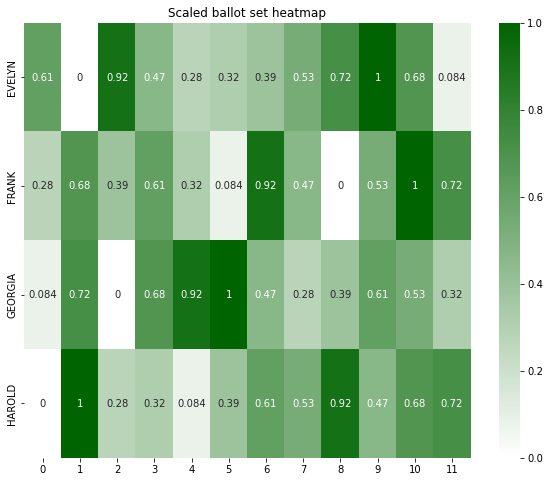

In [ ]:
# Create a custom colormap
# This example uses blue, but you can change 'blue' to any color of your choice.
single_color_cmap = LinearSegmentedColormap.from_list('custom_blue', ['white', 'darkgreen'])

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(symmetric_scaled_quantile_normalized_score_ballot_df, cmap=single_color_cmap, annot=True)
plt.title('Scaled ballot set heatmap')
plt.show()

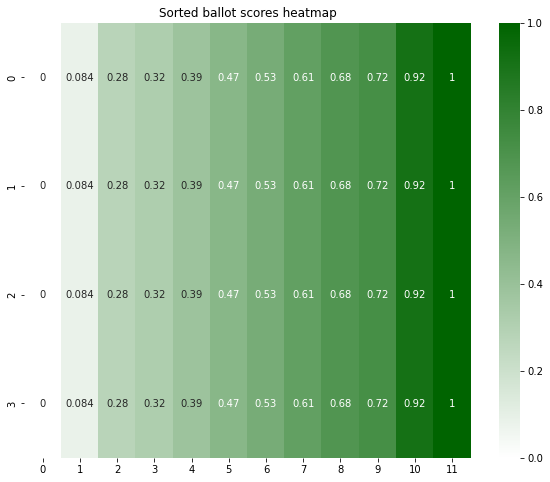

In [ ]:
sorted_scaled_score_matrix = np.sort(symmetric_scaled_quantile_normalized_score_ballot_df, axis=1)
single_color_cmap = LinearSegmentedColormap.from_list('custom_blue', ['white', 'darkgreen'])

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_scaled_score_matrix, cmap=single_color_cmap, annot=True)
plt.title('Sorted ballot scores heatmap')
plt.show()

## Compare with original scaled score ballot set.

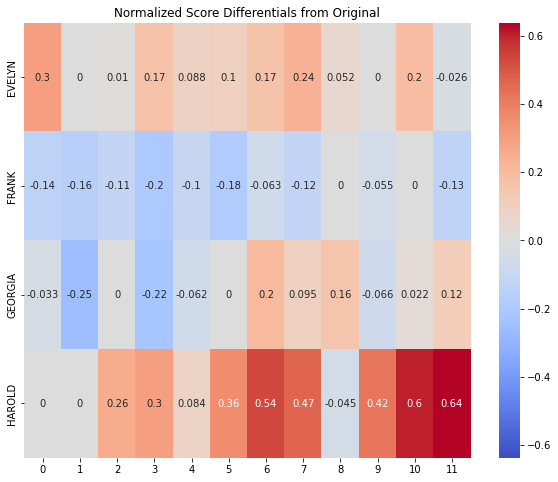

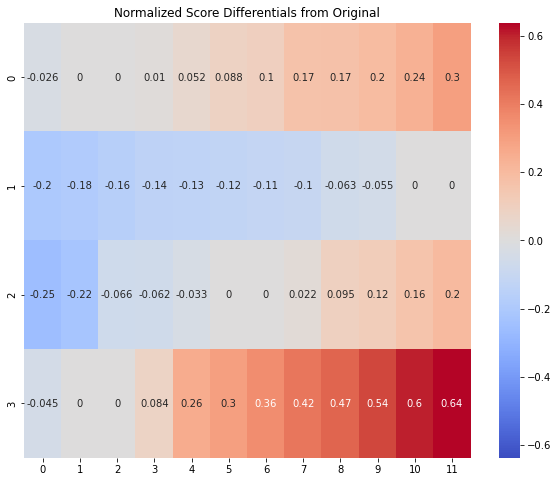

In [ ]:
difference_df = symmetric_scaled_quantile_normalized_score_ballot_df - scaled_score_ballot_df
# Find the maximum absolute value for symmetric color scaling around 0
max_abs_value = difference_df.abs().max().max()
single_color_cmap = LinearSegmentedColormap.from_list('custom_blue', ['white', 'darkgreen'])

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(difference_df, cmap="coolwarm", annot=True,center=0,
            vmin=-max_abs_value, vmax=max_abs_value)
plt.title('Normalized Score Differentials from Original')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(np.sort(difference_df, axis=1), cmap="coolwarm", annot=True,center=0,
            vmin=-max_abs_value, vmax=max_abs_value)
plt.title('Normalized Score Differentials from Original')
plt.show()

## Observe the election results by tallying symmetric quantile-normalized score values for each candidate.

Here an average is computed.

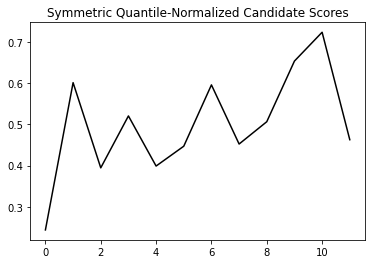

Ranking of candidates by mean normalized score:  [10  9  1  6  3  8 11  7  5  4  2  0]


<AxesSubplot:>

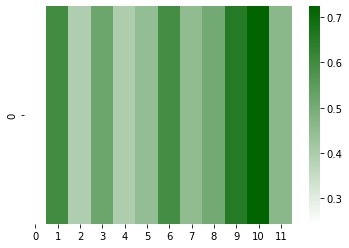

In [ ]:
column_averages = symmetric_scaled_quantile_normalized_score_ballot_df.mean(axis=0)
plt.plot(column_averages, c='k')
plt.title('Symmetric Quantile-Normalized Candidate Scores')
plt.show()
print("Ranking of candidates by mean normalized score: ", np.argsort(list(-column_averages)))
sns.heatmap(np.matrix(column_averages),cmap=single_color_cmap, annot=False)

## Compare with result from scaled score ballot set.

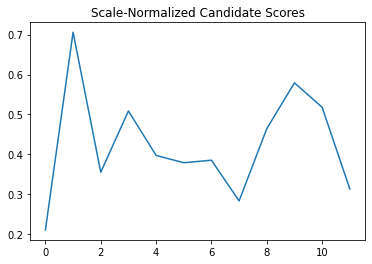

Ranking of candidates by mean un-normalized score:  [ 1  9 10  3  8  4  6  5  2 11  7  0]


<AxesSubplot:>

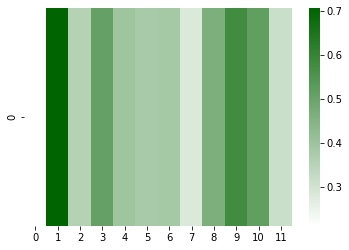

In [ ]:
column_averages = scaled_score_ballot_df.mean(axis=0)
column_averages
plt.plot(column_averages)
plt.title('Scale-Normalized Candidate Scores')
plt.show()

print("Ranking of candidates by mean un-normalized score: ", np.argsort(list(-column_averages)))
sns.heatmap(np.matrix(column_averages),cmap=single_color_cmap, annot=False)

## Also compute ordinary (asymmetrical) quantile normalized score ballot set.

## Compare with result from asymmetrical quantile normalized scaled score ballot set.

column_averages = scaled_score_ballot_df.mean(axis=0)
column_averages
plt.plot(column_averages)
plt.title('Scale-Normalized Candidate Scores')
plt.show()